In [1]:


import pandas as pd
from funcoes import infoclientesum
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     cross_val_score,
                                     cross_val_predict)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer,ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             confusion_matrix)



pd.set_option('display.max_columns', None)

# Qual cliente vai abandonar o cartão de crédito ? 

> Esse notebook se propoẽm a realizar uma analise descritiva dos dados, testar três maneiras distintas de 
> modelagem, logit, random forest e isolation forest, identificando a mais promissora para 
> submeter a base de teste.

>Esta é a [base original]. 


[base original]: https://www.kaggle.com/sakshigoyal7/credit-card-customers "Kaggle"


> obs: como orientado pelo autor, foi retirado previamente as duas ultimas colunas.


In [5]:
#importando a base
bank = pd.read_csv("/home/sandro/Documentos/Projetos/Retencao_de_Clientes/dados/BankChurners.csv")
df = bank.copy()

In [6]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1335.0,1144,42,1625.0,61.00
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1541.0,1291,33,3714.0,105.00
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2594.0,1887,20,2333.0,0.00
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1405.0,1171,20,2333.0,0.76
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2175.0,816,28,2.5,0.00


In [7]:
df.isnull().values.any()

False

> A base não possui nenhum valor faltando 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

>Com uma análise superficial por meio do head() e info(), o type de cada columa está adequado e qualquer tratamento deve ser feito dentro do escopo do tratamento pré-estimação

In [9]:
df.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,682.746275,4404.086304,64.858695,584.326306,247.333503
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,312.204917,3397.129254,23.472570,335.720220,274.452904
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,579.000000,2155.500000,45.000000,438.500000,0.060000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,715.000000,3899.000000,67.000000,655.000000,132.000000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,844.000000,4741.000000,81.000000,786.000000,463.000000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3397.000000,18484.000000,139.000000,3714.000000,999.000000


In [10]:
df.Gender.value_counts(normalize=True)

F    0.529081
M    0.470919
Name: Gender, dtype: float64

In [11]:
df.Attrition_Flag.value_counts(normalize=True)

Existing Customer    0.83934
Attrited Customer    0.16066
Name: Attrition_Flag, dtype: float64

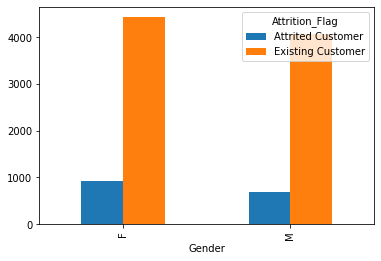

In [12]:
gender_Attrition_Flag = df.groupby(['Gender','Attrition_Flag'])['CLIENTNUM'].count()
_= gender_Attrition_Flag.unstack().plot(kind='bar', stacked=False )


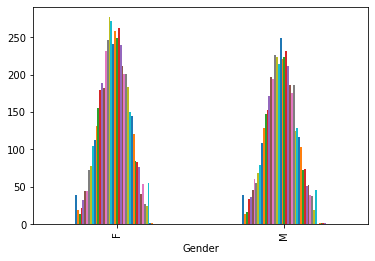

In [13]:
gender_Customer_Age = df.groupby(['Gender','Customer_Age'])['CLIENTNUM'].count()
_= gender_Customer_Age.unstack().plot(kind='bar', stacked=False, legend =False )

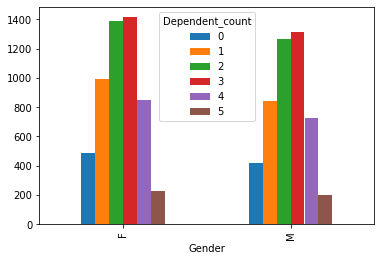

In [14]:
gender_Dependent_count = df.groupby(['Gender','Dependent_count'])['CLIENTNUM'].count()
_= gender_Dependent_count.unstack().plot(kind='bar', stacked=False, legend =True )

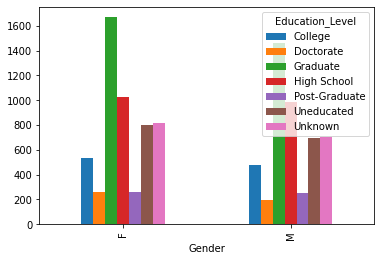

In [15]:
gender_Education_Level = df.groupby(['Gender','Education_Level'])['CLIENTNUM'].count()
_= gender_Education_Level.unstack().plot(kind='bar', stacked=False, legend =True)

#arrumar essa legenda

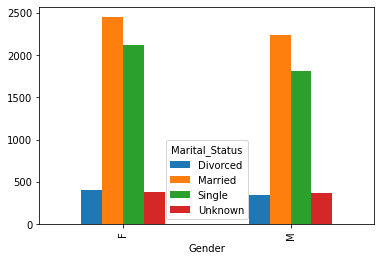

In [16]:
gender_Marital_Status = df.groupby(['Gender','Marital_Status'])['CLIENTNUM'].count()
_= gender_Marital_Status.unstack().plot(kind='bar', stacked=False, legend =True)



> Análisando as distribições de clientes por gênero para as fatures Attrition_Flag, Customer_Age,Dependent_count, Education_Level e Marital_Status, podemos perceber que existe distribuição bem proxima entre ambos dos gêneros, com destaque para o desbalanecamento entre os dois estados de Attrition_Flag, que é similar e dessa maneira as escolhas para adequação dos dados para a modelagem possuem menor probabilidade de serem inviabilizados.     


In [17]:
print(df.columns.values)

['CLIENTNUM' 'Attrition_Flag' 'Customer_Age' 'Gender' 'Dependent_count'
 'Education_Level' 'Marital_Status' 'Income_Category' 'Card_Category'
 'Months_on_book' 'Total_Relationship_Count' 'Months_Inactive_12_mon'
 'Contacts_Count_12_mon' 'Credit_Limit' 'Total_Revolving_Bal'
 'Avg_Open_To_Buy' 'Total_Amt_Chng_Q4_Q1' 'Total_Trans_Amt'
 'Total_Trans_Ct' 'Total_Ct_Chng_Q4_Q1' 'Avg_Utilization_Ratio']


In [18]:
#transformando a coluna Attrition_Flag de catogorica para booleana 

df['Attrition_Flag'] = np.where(df['Attrition_Flag']=='Existing Customer',0,1)

In [19]:
#Listando fatures e target 
fatures = ['Customer_Age','Gender','Dependent_count',  'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal','Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']
target = ['Attrition_Flag']

x = df[fatures]
y = df[target]

#Dividindo a base entre treino e teste,

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=0, stratify = y)

In [32]:
#pre process objects
fatures_num = list(df.select_dtypes('float64','int64').columns) 
fatures_cat = list(df.select_dtypes('object').columns)
imputer_num = SimpleImputer(strategy="median")
imputer_cat = SimpleImputer(strategy="most_frequent")
ohe = OneHotEncoder(handle_unknown = 'ignore')
sts = StandardScaler()

cat_pipeline = make_pipeline(imputer_cat,ohe)
num_pipeline = make_pipeline(imputer_num,sts)


In [28]:
# Pipeline objects

preprocess = make_column_transformer(
    ([fatures_num],num_pipeline ),
    ([fatures_cat],cat_pipeline )
)

logistic_regression = LogisticRegression(n_jobs=-1)
poly = PolynomialFeatures(interaction_only=True)

pipe_logit = make_pipeline(preprocess,logistic_regression)



In [29]:
#Fit
pipe_logit.fit(x_train,y_train)

TypeError: All estimators should implement fit and transform, or can be 'drop' or 'passthrough' specifiers. '[['Credit_Limit', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']]' (type <class 'list'>) doesn't.